In [6]:
import numpy, scipy, matplotlib.pyplot as plt, pandas as pd
import sklearn, IPython.display as ipd
import librosa, librosa.display
import itertools

from sklearn.metrics import *
from pathlib import Path
%matplotlib inline

from sklearn.multiclass import OneVsRestClassifier

## Step 1: Retrieve Audio

In [2]:
c1_signals = [
    librosa.load(p, duration=30, offset=10)[0] for p in Path().glob('audio/train/c1/*.mp3')
]
c2_signals = [
    librosa.load(p, duration=30, offset=10)[0] for p in Path().glob('audio/train/c2/*.mp3')
]
c3_signals = [
    librosa.load(p, duration=30, offset=10)[0] for p in Path().glob('audio/train/c3/*.mp3')
]

In [3]:
print(len(c1_signals))
print(len(c2_signals))
print(len(c3_signals))

100
100
100


## Step 2: Extract Features

In [4]:
n_mfcc = 12
hop_length = 512
def extract_features(signal):
    zcr = librosa.feature.zero_crossing_rate(signal).mean()
    cent = librosa.feature.spectral_centroid(signal).mean()
    mfccs = librosa.feature.mfcc(signal, n_mfcc=n_mfcc).mean()
    S = librosa.feature.melspectrogram(signal).mean()
    tempo = librosa.feature.tempogram(signal, hop_length=hop_length).mean()
    rmse = librosa.feature.rmse(signal, hop_length=hop_length).mean()
    chroma = librosa.feature.chroma_stft(signal).mean()
    spec_bw = librosa.feature.spectral_bandwidth(signal).mean()
    return [zcr, cent, mfccs, S, tempo, rmse, chroma, spec_bw]

In [7]:
c1_features = numpy.array([extract_features(x) for x in c1_signals])
c2_features = numpy.array([extract_features(x) for x in c2_signals])
c3_features = numpy.array([extract_features(x) for x in c3_signals])

/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_agg[idx_agg] = aggregate(data[idx_in], axis=axis)
/home/kameswar/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tu

In [8]:
print(c1_features.shape)
print(c2_features.shape)
print(c3_features.shape)

(100, 8)
(100, 8)
(100, 8)


## Step 3: Train the Classifier

In [9]:
#scaler = sklearn.preprocessing.StandardScaler()
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))

c1_features_scaled = scaler.fit_transform(c1_features)
print(c1_features_scaled.mean(axis=0))
print(c1_features_scaled.std(axis=0))

c2_features_scaled = scaler.transform(c2_features)
print(c2_features_scaled.mean(axis=0))
print(c2_features_scaled.std(axis=0))

c3_features_scaled = scaler.transform(c3_features)
print(c3_features_scaled.mean(axis=0))
print(c3_features_scaled.std(axis=0))

[-0.23336744 -0.08948801  0.12649063 -0.51290256 -0.15395375 -0.21921891
 -0.27510573 -0.09310684]
[0.46218705 0.38335149 0.46212865 0.37861044 0.43241216 0.38094568
 0.35045076 0.35457033]
[-0.36488162  0.16760711  0.11460639 -0.72234962 -0.07585366 -0.52252048
 -0.01492442  0.48434216]
[0.57286357 0.505123   0.56765696 0.28821355 0.53063895 0.32892931
 0.43578074 0.32568216]
[-0.4866333   0.05015285  0.32460485 -0.37878482 -0.1698694  -0.20072424
  0.07717739  0.35776427]
[0.47097336 0.41518885 0.58328218 0.55828309 0.55116693 0.44234508
 0.57474021 0.3051282 ]


In [10]:
train_features = numpy.vstack((c1_features_scaled, c2_features_scaled, c3_features_scaled))
print(train_features.shape)
print(train_features.min(axis=0))
print(train_features.max(axis=0))

(300, 8)
[-1.50562137 -1.         -1.35085151 -1.01270722 -1.06488029 -1.07418495
 -1.         -1.        ]
[1.5849273  1.81745481 1.22350598 1.67416138 1.36919755 1.
 2.0117758  1.09160228]


In [11]:
train_labels = numpy.concatenate((numpy.zeros(len(c1_features_scaled)), numpy.ones(len(c2_features_scaled)), numpy.full(len(c3_features_scaled),2)))

In [12]:
print(train_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [13]:
# parameters = {'weights':('uniform', 'distance'), 'n_neighbors':[1, 3, 5, 7]}
# knn = sklearn.neighbors.KNeighborsClassifier()
# model = GridSearchCV(knn, parameters)

In [14]:
model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

In [15]:
#OneVsRest
# X,y = train_features, train_labels
# y_true = test_labels
# model = OneVsRestClassifier(sklearn.linear_model.LogisticRegression(random_state=0)).fit(X, y)
# model.predict(X)
# model.score(X,y)

In [16]:
acc  = sklearn.model_selection.cross_val_score(model, train_features, train_labels, cv=10)

In [17]:
print('acc =', acc)
print ('acc mean =',acc.mean())

acc = [0.7        0.7        0.66666667 0.66666667 0.53333333 0.73333333
 0.5        0.53333333 0.53333333 0.76666667]
acc mean = 0.6333333333333333


In [18]:
model.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

## Step 4: Run the Classifier

In [19]:
c1_test_signals = [
    librosa.load(p, duration=30, offset=60)[0] for p in Path().glob('audio/test/c1/*.mp3')
]
c2_test_signals = [
    librosa.load(p, duration=30, offset=60)[0] for p in Path().glob('audio/test/c2/*.mp3')
]
c3_test_signals = [
    librosa.load(p, duration=30, offset=60)[0] for p in Path().glob('audio/test/c3/*.mp3')
]

In [20]:
print(len(c1_test_signals))
print(len(c2_test_signals))
print(len(c3_test_signals))

25
25
25


In [21]:
c1_test_features = numpy.array([extract_features(x) for x in c1_test_signals])
c2_test_features = numpy.array([extract_features(x) for x in c2_test_signals])
c3_test_features = numpy.array([extract_features(x) for x in c3_test_signals])

/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_agg[idx_agg] = aggregate(data[idx_in], axis=axis)
/home/kameswar/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tu

In [22]:
print(c1_test_features.shape)
print(c2_test_features.shape)
print(c3_test_features.shape)

(25, 8)
(25, 8)
(25, 8)


In [23]:
c1_test_features_scaled = scaler.transform(c1_test_features)
c2_test_features_scaled = scaler.transform(c2_test_features)
c3_test_features_scaled = scaler.transform(c3_test_features)

In [24]:
test_features = numpy.vstack((c1_test_features_scaled, c2_test_features_scaled, c3_test_features_scaled))

In [25]:
test_labels = numpy.concatenate((numpy.zeros(len(c1_test_features)), numpy.ones(len(c2_test_features)), np.full(len(c2_test_features), 2)))

In [26]:
print(test_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2.]


In [27]:
predicted_labels = model.predict(test_features)

In [28]:
predicted_labels

array([0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 2., 1., 1., 0., 1., 2., 1., 2., 1., 2.,
       2., 2., 2., 0., 1., 1., 0., 2., 2., 0., 0., 2., 0., 1., 1., 1., 2.,
       2., 2., 0., 2., 2., 2., 2., 2., 0., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 0., 0., 2., 2., 2., 2.])

## Step 5: Evaluation

### Classification Metrics

In [29]:
score = model.score(test_features, test_labels)
accuracy = accuracy_score(test_labels, predicted_labels)
cohen_kappa = cohen_kappa_score(test_labels, predicted_labels)

In [30]:
classification_metrics = [score, accuracy, cohen_kappa]
classification_metrics_labels = ['score', 'accuracy', 'cohen_kappa']

In [31]:
pd.DataFrame(classification_metrics, classification_metrics_labels)

,0
score,0.68
accuracy,0.68
cohen_kappa,0.52


### Regression Metrics

In [32]:
r2 = r2_score(test_labels, predicted_labels)
explained_variance_score = explained_variance_score(test_labels, predicted_labels)
mean_squared_error = mean_squared_error(test_labels, predicted_labels)

In [33]:
regression_metrics = [r2, explained_variance_score, mean_squared_error]
regression_metrics_labels = ['r2_score', 'explained_variance_score', 'mean_squared_error']

In [34]:
pd.DataFrame(regression_metrics, regression_metrics_labels)

,0
r2_score,0.1000
explained_variance_score,0.1024
mean_squared_error,0.6000


### Confusion Matrix

In [35]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = [0,1,2]

In [36]:
confusion_matrix(test_labels, predicted_labels)

array([[20,  2,  3],
       [ 6, 10,  9],
       [ 4,  0, 21]])

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[20  2  3]
 [ 6 10  9]
 [ 4  0 21]]
Normalized confusion matrix
[[0.8  0.08 0.12]
 [0.24 0.4  0.36]
 [0.16 0.   0.84]]


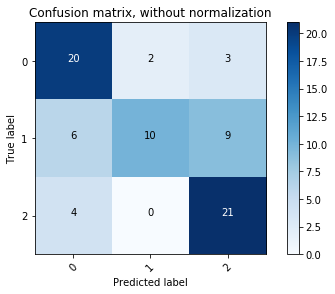

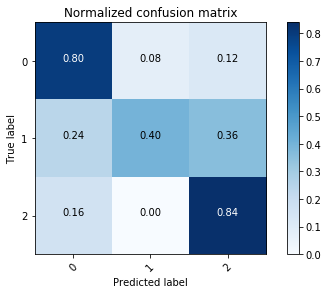

In [39]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()